In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
import pandas as pd

In [2]:
def get_experiment_repeat_directories(exp_dir, repeat_prefix):
    exp_path = Path(experiment_dir)
    sub_dirs = list(exp_path.glob("**"))
    repeat_dirs = []

    for d in sub_dirs:
        if repeat_prefix in d.stem:
            repeat_dirs.append(d.absolute())

    return repeat_dirs

def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
        return data
    

def load_all_particles(repeat_dirs):
    all_particles = []
    for d in repeat_dirs:
        particle_paths = d.glob("particles_*.pkl")
        for p_path in particle_paths:
            all_particles.extend(load_pickle(p_path))
            
    return all_particles

def filter_particles_by_distance(particles, epsilon):
    print(epsilon)
    filtered_particles = []
    for p in particles:
        flag = True
        for idx, eps in enumerate(epsilon):
            if p.distance[idx] > eps:
                flag = False
                
        if flag:
            filtered_particles.append(p)
    
    return filtered_particles

def get_solution_index(comm, sol_element_key):
    idx = comm.solution_keys.index(sol_element_key)
    return idx

def plot_particle_and_data(particle, exp_data_df, exp_sol_keys, exp_t_key, subplots_shape):
    sns.set_context("talk")
    sns.set_style("white")

    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, axes = plt.subplots(nrows=subplots_shape[0], ncols=subplots_shape[1], figsize=(width_inches, height_inches))
    if isinstance(axes, np.ndarray):
        axes = axes.reshape(-1)
    
    else:
        axes = [axes]
    
    for idx, key_pair in enumerate(exp_sol_keys):
        ax = axes[idx]
        sol_idx = get_solution_index(particle, key_pair[1])
        print(key_pair, sol_idx)

        print(particle.sol[:, sol_idx].mean())
        sns.lineplot(x=particle.t, y=particle.sol[:, sol_idx].reshape(-1), 
                     label=f'sim_{sol_idx}', color='orange', ax=ax)
        ax.set_title(f"key:{key_pair[1]}, dist: {particle.distance[idx]:.4}")

        for idx, t in enumerate(exp_data_df[exp_t_key].values):
            
            exp_val = exp_data_df.loc[exp_data_df[exp_t_key] == t][
                key_pair[0]
            ].values[0]

            if np.isnan(exp_val):
                continue
            else:
                ax.scatter(t, exp_val, label=key_pair[0], color='black')
        
        ax.set(xlim=(-0.5,None))
        ax.set(ylim=(-0))
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_alpha(0.5)
        ax.spines["bottom"].set_alpha(0.5)
        ax.tick_params(labelsize=15)
        ax.margins(x=0)
        ax.margins(y=0)
        fig.tight_layout()

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())


def plot_all_particles(particles, exp_data_df, exp_sol_keys, exp_t_key, subplots_shape):
    sns.set_context("talk")
    sns.set_style("white")

    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, axes = plt.subplots(nrows=subplots_shape[0], ncols=subplots_shape[1], figsize=(width_inches, height_inches))
    if isinstance(axes, np.ndarray):
        axes = axes.reshape(-1)
    
    else:
        axes = [axes]
    
    for idx, key_pair in enumerate(exp_sol_keys):
        ax = axes[idx]

        for particle in particles:
            sol_idx = get_solution_index(particle, key_pair[1])
            sns.lineplot(x=particle.t, y=particle.sol[:, sol_idx].reshape(-1), 
                         label=f'sim_{sol_idx}', color='orange', alpha=0.25, ax=ax)
        ax.set_title(f"key:{key_pair[1]}, dist: {particle.distance[idx]:.4}")

        for idx, t in enumerate(exp_data_df[exp_t_key].values):
            
            exp_val = exp_data_df.loc[exp_data_df[exp_t_key] == t][
                key_pair[0]
            ].values[0]

            if np.isnan(exp_val):
                continue
            else:
                ax.scatter(t, exp_val, label=key_pair[0], color='black')
        
        ax.set(xlim=(-0.5,None))
        ax.set(ylim=(-0))
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_alpha(0.5)
        ax.spines["bottom"].set_alpha(0.5)
        ax.tick_params(labelsize=15)
        ax.margins(x=0)
        ax.margins(y=0)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
#         plt.legend(by_label.values(), by_label.keys())
        ax.legend(by_label.values(), by_label.keys())

        fig.tight_layout()
    
    return axes

def generate_particle_parameter_df(particles):
    init_particle = particles[0]
    
    column_headings = [f'init_{x}' for x in init_particle.model_names]
    init_conc_cols = [f'init_{x}' for x in init_particle.dynamic_compounds]

    k_val_cols = []
    lb_constraint_cols = []
    
    for m in init_particle.model_names:
        # Make column headings
        k_val_cols += [f'K_{x}_{m}' for x in init_particle.dynamic_compounds]
        lb_constraint_cols += [f'lb_constr_{x}_{m}' for x in init_particle.dynamic_compounds] 

    column_headings += init_conc_cols + k_val_cols + lb_constraint_cols

    parameters = np.zeros([len(particles), len(column_headings)])
    for idx, p in enumerate(particles):
        parameters[idx] = p.generate_parameter_vector().reshape(-1)

    df = pd.DataFrame(data=parameters, columns=column_headings)
    return df


In [3]:
# p = filtered_particles[-1]
# print(p.k_vals.shape)
# print(p.max_exchange_mat.shape)
# print(np.shape(p.dynamic_compounds))
# print(p.init_y.shape)

# x = np.array([[11, 12, 13], [21,22, 23]])
# print(x)
# print(x.reshape(1, -1))

# x = generate_particle_parameter_df(filtered_particles)


In [4]:
experiment_dir = '../output/exp_lactis_iMM904_coculture_ga_fit/'
epsilon = [100.0, 0.25]

# experiment_dir = '../output/exp_yeast_ga_fit/'

# experiment_dir = '../output/exp_lactis_ga_fit/'
# epsilon = [0.01]

experiment_dir = '../output/exp_iMM904_ga_fit/'
epsilon = [1.5]


repeat_prefix = 'run_'
run_dirs = get_experiment_repeat_directories(experiment_dir, repeat_prefix)
particles = load_all_particles(run_dirs)
filtered_particles = filter_particles_by_distance(particles, epsilon=epsilon)
print(len(filtered_particles))
print(dir(filtered_particles[-1]))
print(filtered_particles[-1].k_vals)


[1.5]
1057
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'accepted_flag', 'calculate_exchange_reaction_lb_constraints', 'compound_indexes', 'diff_eqs', 'diff_eqs_vode', 'distance', 'dynamic_compounds', 'generate_default_k_values', 'generate_initial_population_densities', 'generate_parameter_vector', 'get_dynamic_compounds', 'init_compound_values', 'init_population_values', 'init_y', 'k_vals', 'load_initial_compound_values', 'load_parameter_vector', 'load_populations', 'lower_constraints', 'max_exchange_mat', 'media_df', 'media_path', 'model_names', 'model_paths', 'population_indexes', 'populations', 'print_sol', 'reaction_keys', 'set_compound_indexes', 'set_init_y', 'set_k_value_matrix', 'set

In [6]:
p = filtered_particles[-1]
p.populations[0].model.optimize().to_frame()


# exp_sol_keys = [
# #     ["yeast_dcw", "iMM904"],
#     ["lactis_dcw", "L_lactis_fbc"],
# ]

# plot_all_particles(particles=filtered_particles[:100], exp_data_df=exp_data, exp_t_key='time', 
#                    exp_sol_keys=exp_sol_keys, subplots_shape=[1, 1])

AttributeError: 'Population' object has no attribute 'model'

['yeast_dcw', 'iMM904'] 0
0.6579316750177157


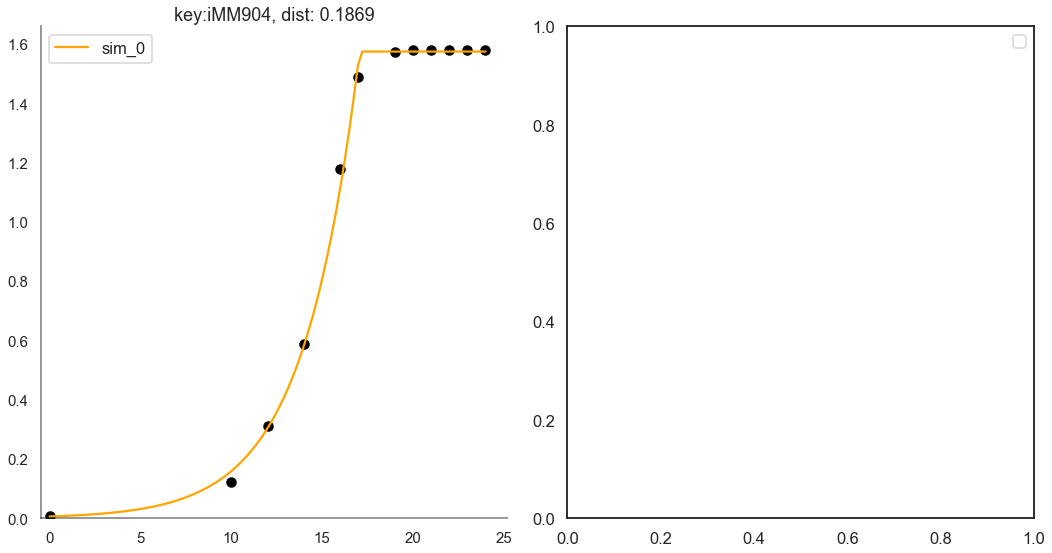

In [11]:
# exp_sol_keys = [
# #     ["yeast_dcw", "iMM904"],
#     ["lactis_dcw", "L_lactis_fbc"],
# ]

exp_sol_keys = [
    ["yeast_dcw", "iMM904"],
#     ["lactis_yeast_dcw", "L_lactis_fbc"],
]

exp_data = pd.read_csv("../experimental_data/Figure1B_fake_data.csv")

plot_particle_and_data(particle=filtered_particles[0], exp_data_df=exp_data, 
                       exp_t_key='time', exp_sol_keys=exp_sol_keys, subplots_shape=[1, 2])

array([<AxesSubplot:title={'center':'key:iMM904, dist: 0.9847'}>,
       <AxesSubplot:>], dtype=object)

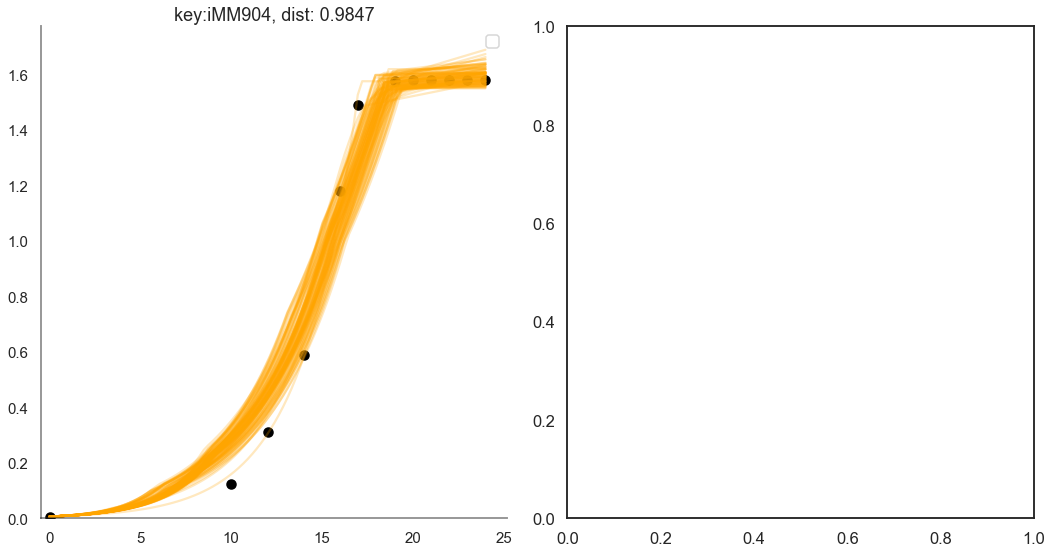

In [12]:
plot_all_particles(particles=filtered_particles[0:100], exp_data_df=exp_data, exp_t_key='time', 
                   exp_sol_keys=exp_sol_keys, subplots_shape=[1, 2])

In [30]:
df = generate_particle_parameter_df(filtered_particles)

In [14]:
# Drop constant columns
sub_df = df.copy(deep=True)
for col in df.columns:
    if len(df[col].unique()) == 1:
        sub_df.drop(col, inplace=True, axis=1)


In [15]:
k_val_columns = [x for x in sub_df.columns if 'K_' in x]
lb_constr_columns = [x for x in sub_df.columns if 'lb_constr_' in x]

In [16]:
k_sub_df = sub_df[k_val_columns]
lb_constr_sub_df = sub_df[lb_constr_columns]

In [17]:
def plot_boxplot(data):
    sns.set_context("talk")
    sns.set_style("white")

    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, ax = plt.subplots(figsize=(width_inches, height_inches))
    sns.boxplot(data=data, color='#8093F1')

    ax.set(xlim=(-0.5,None))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_alpha(0.5)
    ax.spines["bottom"].set_alpha(0.5)
    ax.tick_params(labelsize=9)
    # ax.set_yscale('symlog')
    # ax.set(xticklabels=[])
    # ax.margins(x=0)
    # ax.margins(y=0)
    plt.xticks(rotation=90)

    fig.tight_layout()


def plot_sampling_distributions():
    import sampling

    dist_1 = sampling.SampleSkewNormal(loc=-2.0, scale=0.5, alpha=0.0, clip_above_zero=False)
    dist_2 = sampling.SampleUniform(
        min_val=1e-3, max_val=1e-1, distribution="log_uniform"
    )

    max_uptake_sampler = multi_dist = sampling.MultiDistribution(
        dist_1, dist_2, prob_dist_1=0.95
    )
    k_val_sampler = sampling.SampleUniform(
        min_val=1e-5, max_val=2.0, distribution="log_uniform"
    )

    lb_sample = max_uptake_sampler.sample(size=[10000,1])
    k_sample = k_val_sampler.sample(size=[10000,1])

    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4


    fig, ax = plt.subplots(ncols=2, figsize=(width_inches, height_inches))
    ax[0].set_title('lower bound constraint distribution')
    ax[1].set_title('k value constraint distribution')

    _ = ax[0].hist(lb_sample, bins=50)

    bins=np.logspace(np.log10(1e-5),np.log10(2.0), 25)

    _ = ax[1].hist(k_sample, bins=bins)
    ax[1].set_xscale('log')

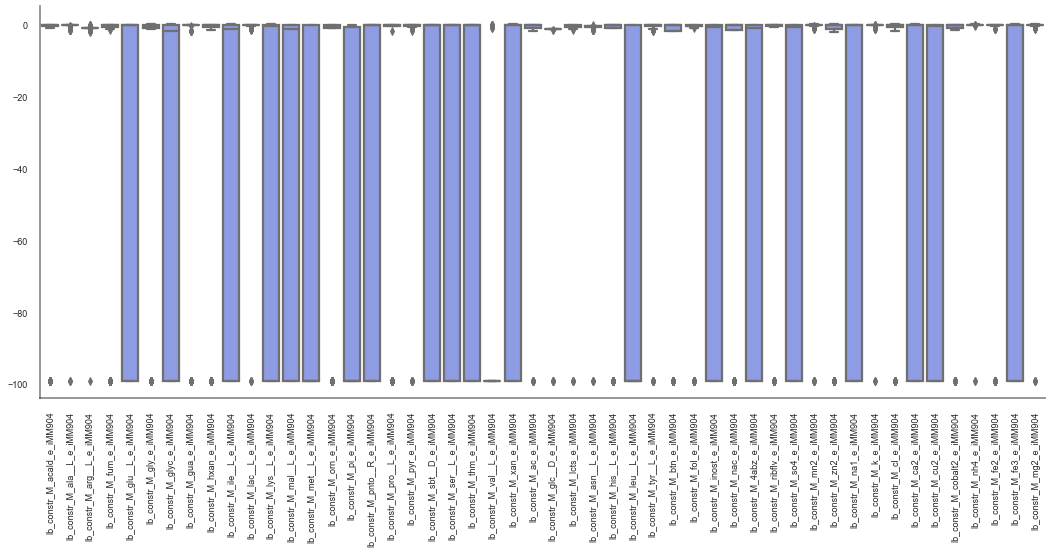

In [19]:
plot_boxplot(lb_constr_sub_df)

In [24]:
for x in df.columns:
    print(x)

init_iMM904
init_M_acald_e
init_M_ala__L_e
init_M_arg__L_e
init_M_fum_e
init_M_glu__L_e
init_M_gly_e
init_M_glyc_e
init_M_gua_e
init_M_hxan_e
init_M_ile__L_e
init_M_lac__L_e
init_M_lys__L_e
init_M_mal__L_e
init_M_met__L_e
init_M_orn_e
init_M_pi_e
init_M_pnto__R_e
init_M_pro__L_e
init_M_pyr_e
init_M_sbt__D_e
init_M_ser__L_e
init_M_thm_e
init_M_val__L_e
init_M_xan_e
init_M_ac_e
init_M_glc__D_e
init_M_lcts_e
init_M_asn__L_e
init_M_his__L_e
init_M_leu__L_e
init_M_tyr__L_e
init_M_btn_e
init_M_fol_e
init_M_inost_e
init_M_nac_e
init_M_4abz_e
init_M_ribflv_e
init_M_so4_e
init_M_mn2_e
init_M_zn2_e
init_M_na1_e
init_M_k_e
init_M_cl_e
init_M_ca2_e
init_M_cu2_e
init_M_cobalt2_e
init_M_nh4_e
init_M_fe2_e
init_M_fe3_e
init_M_mg2_e
K_M_acald_e_iMM904
K_M_ala__L_e_iMM904
K_M_arg__L_e_iMM904
K_M_fum_e_iMM904
K_M_glu__L_e_iMM904
K_M_gly_e_iMM904
K_M_glyc_e_iMM904
K_M_gua_e_iMM904
K_M_hxan_e_iMM904
K_M_ile__L_e_iMM904
K_M_lac__L_e_iMM904
K_M_lys__L_e_iMM904
K_M_mal__L_e_iMM904
K_M_met__L_e_iMM904
K_M_orn

In [34]:
df = df.loc[df['lb_constr_M_glu__L_e_iMM904'] > 0.0]

In [35]:
df

,init_iMM904,init_M_acald_e,init_M_ala__L_e,init_M_arg__L_e,init_M_fum_e,init_M_glu__L_e,init_M_gly_e,init_M_glyc_e,init_M_gua_e,init_M_hxan_e,...,lb_constr_M_na1_e_iMM904,lb_constr_M_k_e_iMM904,lb_constr_M_cl_e_iMM904,lb_constr_M_ca2_e_iMM904,lb_constr_M_cu2_e_iMM904,lb_constr_M_cobalt2_e_iMM904,lb_constr_M_nh4_e_iMM904,lb_constr_M_fe2_e_iMM904,lb_constr_M_fe3_e_iMM904,lb_constr_M_mg2_e_iMM904
157,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.036698,-0.005504,-0.375806,-0.098993,-1.26011,-0.036237,0.013826,-0.118947,-0.058925,-0.027982
186,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.036698,-0.005504,-0.375806,-0.098993,-1.26011,-0.725748,0.013826,-0.118947,-0.146266,-0.027982
249,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.079271,-0.246531,-0.004142,-0.098993,-0.09462,-0.256956,-0.001399,-0.001718,-0.053140,-0.056985


In [88]:
def plot_tsne(df):
    from sklearn import manifold
    tsne = manifold.TSNE(n_components=2, n_jobs=5).fit_transform(df)
    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, ax = plt.subplots(figsize=(width_inches, height_inches))
    ax.scatter(x=tsne[:, 0], y=tsne[:, 1], s=3)

    # ax.set(xlim=(-0.5,None))
    # ax.set(ylim=(-0))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_alpha(0.5)
    ax.spines["bottom"].set_alpha(0.5)
    ax.tick_params(labelsize=15)
    ax.margins(x=0)
    ax.margins(y=0)
    fig.tight_layout()



In [29]:
df

,init_iMM904,init_M_acald_e,init_M_ala__L_e,init_M_arg__L_e,init_M_fum_e,init_M_glu__L_e,init_M_gly_e,init_M_glyc_e,init_M_gua_e,init_M_hxan_e,...,lb_constr_M_na1_e_iMM904,lb_constr_M_k_e_iMM904,lb_constr_M_cl_e_iMM904,lb_constr_M_ca2_e_iMM904,lb_constr_M_cu2_e_iMM904,lb_constr_M_cobalt2_e_iMM904,lb_constr_M_nh4_e_iMM904,lb_constr_M_fe2_e_iMM904,lb_constr_M_fe3_e_iMM904,lb_constr_M_mg2_e_iMM904
0,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.346841,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.013826,-99.000000,0.045979,-0.081190
1,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.000000,-0.001519,-0.183923,-0.021410,-99.000000,-0.657225,-0.011536,-0.001857,-0.024495,-0.013286
2,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.034267,-0.023659,-0.024540,-0.053266,-0.001053,-0.838819,-0.011536,-0.323151,-99.000000,-0.265861
3,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083659,-0.009705,-0.017924,-0.021410,-0.006063,-0.033385,-0.001570,-0.002334,-1.756442,-0.409564
4,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.048394,-0.064306,-1.525653,-99.000000,-99.000000,-0.066294,0.000018,-99.000000,-0.001573,0.035754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.000000,-0.541046,-0.001331,-99.000000,-1.753642,-0.557838,-0.013726,-0.002569,-99.000000,-0.054314
155,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.000000,-0.051925,-0.788253,-99.000000,-0.258658,-99.000000,-99.000000,-99.000000,-0.164844,-99.000000
156,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.004260,-99.000000,-0.001009,-0.007278,-0.010475,-99.000000,-0.475797,-1.174115,-99.000000,-99.000000
157,0.0062,0.0,0.0,4.13318,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.250133,-0.033890,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-0.027014,-0.747493


In [97]:
def plot_correlation_heatmap(df):
    # Colors

    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, ax = plt.subplots(figsize=(width_inches, height_inches))
    cmap = sns.diverging_palette(500, 10, as_cmap=True).reversed()
    ax.tick_params(labelsize=8)
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False, cmap=cmap, ax=ax)
    


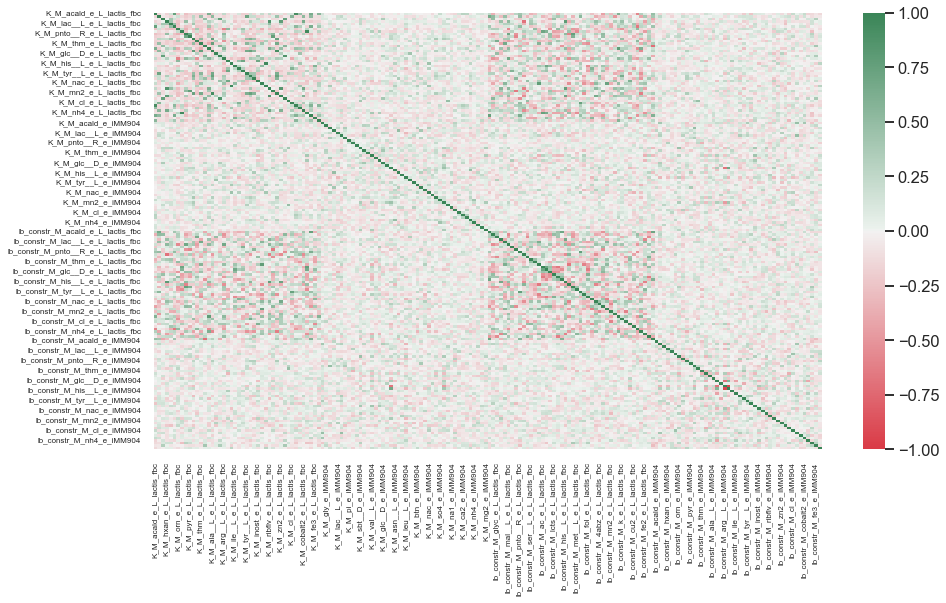

In [90]:
plot_correlation_heatmap(sub_df)

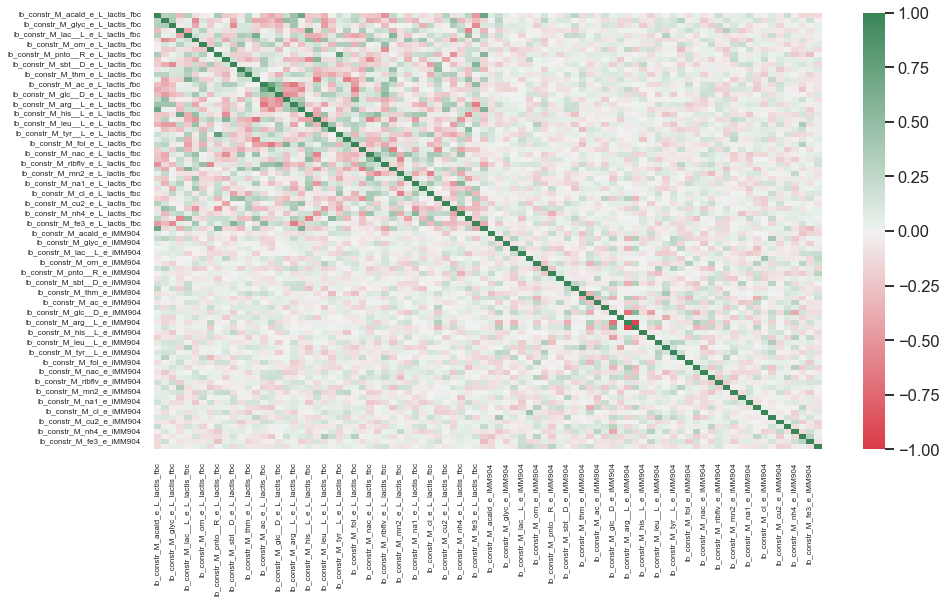

In [91]:
plot_correlation_heatmap(lb_constr_sub_df)

/Users/bezk/opt/miniconda3/envs/cobrapy_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bezk/opt/miniconda3/envs/cobrapy_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


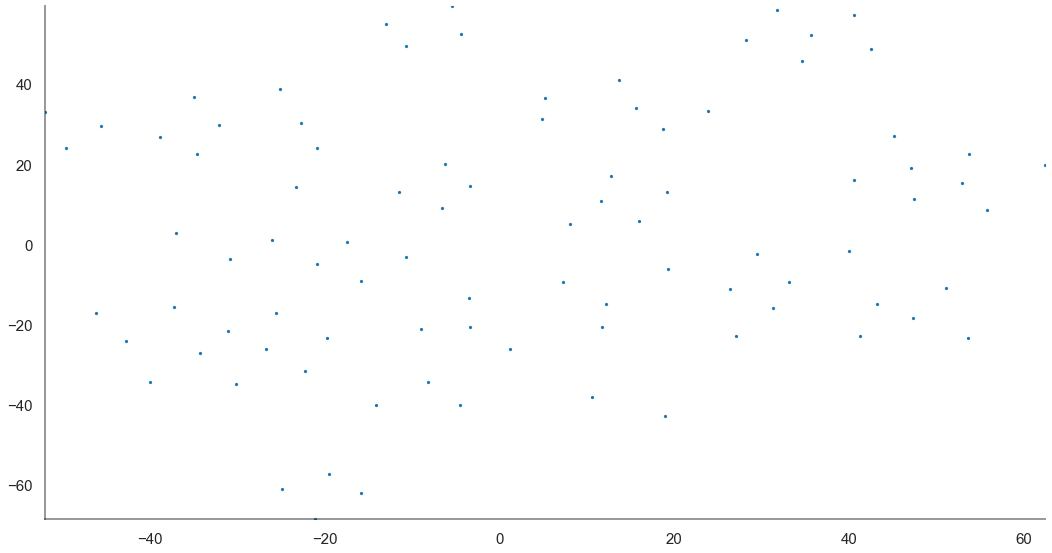

In [92]:
plot_tsne(lb_constr_sub_df)

/Users/bezk/opt/miniconda3/envs/cobrapy_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bezk/opt/miniconda3/envs/cobrapy_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


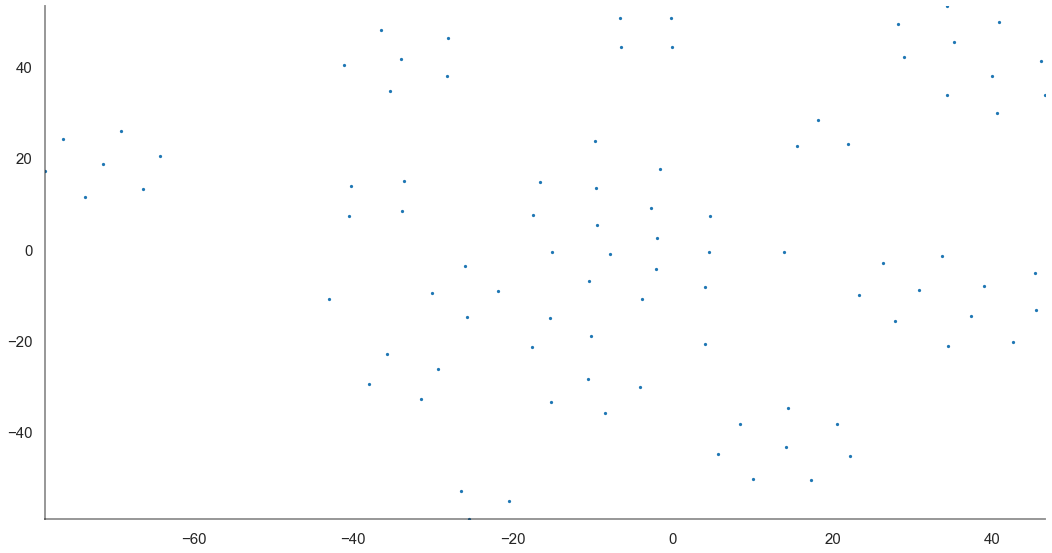

In [93]:
plot_tsne(sub_df)

In [ ]:
print("Population can have positive lb constraint (exporter): ")
for col in lb_constr_columns:
    if lb_constr_sub_df[col].max() > 0:
        print(sum(lb_constr_sub_df[col] > 0), f"\t{col}")
        print(sum(lb_constr_sub_df[col] < 0), f"\t{col}")

In [ ]:
print("Population has only neagtive lb constraint (importer): ")
for col in lb_constr_columns:
    if lb_constr_sub_df[col].max() < 0:
        print(f"\t{col}")